# IMPORTS

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import cv2
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


2024-04-03 21:25:43.451657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 21:25:43.451707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 21:25:43.453311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Image Files from Dataset Directory

In [2]:
# Loading imgs 
imgs=glob.glob('/kaggle/input/english-handwritten-characters-dataset/Img/*')

# Loading csv file
df = pd.read_csv("/kaggle/input/english-handwritten-characters-dataset/english.csv")
df.head(6)

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0
5,Img/img001-006.png,0


Shape of the original image: (900, 1200, 3)


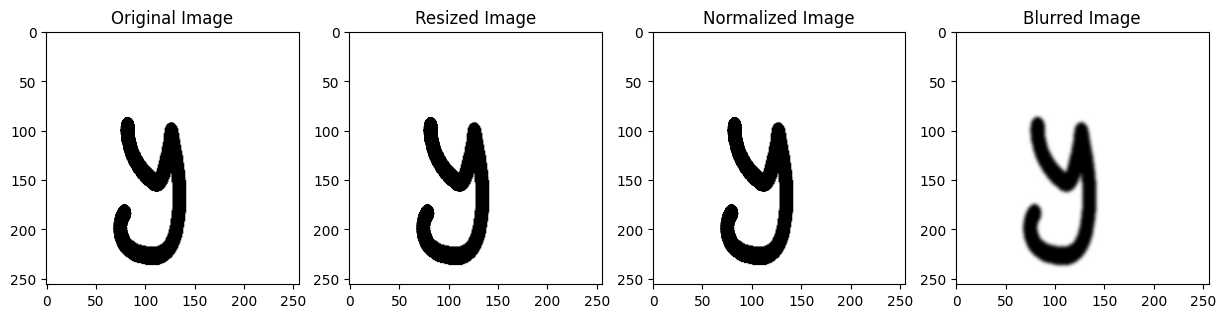

In [3]:
original_img = cv2.imread(imgs[22])

# Print the shape of the original image
print(f"Shape of the original image: {original_img.shape}")

# Resize the original image to a larger size
original_img_resized = cv2.resize(original_img, (256, 256))

# Convert color space from BGR to RGB
original_img_resized_rgb = cv2.cvtColor(original_img_resized, cv2.COLOR_BGR2RGB)

# Normalize pixel values to the range [0, 1]
original_img_resized_normalized = original_img_resized_rgb / 255.0

# Apply Gaussian blur with larger kernel size and sigma
blurred_img = cv2.GaussianBlur(original_img_resized_normalized, (9, 9), 0)

# Plotting
plt.figure(figsize=(15, 5))

# Plot original image
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(original_img_resized_rgb)
plt.axis('on')

# Plot resized image
plt.subplot(1, 4, 2)
plt.title('Resized Image')
plt.imshow(original_img_resized_rgb)
plt.axis('on')

# Plot normalized image
plt.subplot(1, 4, 3)
plt.title('Normalized Image')
plt.imshow(original_img_resized_normalized)
plt.axis('on')

# Plot blurred image
plt.subplot(1, 4, 4)
plt.title('Blurred Image')
plt.imshow(blurred_img)
plt.axis('on')

plt.show()

# Data Preparation and Preprocessing for Image Classification Model

In [4]:
# Sorting image paths
new_imgs = sorted(imgs)

# Listing labels
labels = df['label'].tolist()

# Encode labels
Encoder = LabelEncoder()
labels = Encoder.fit_transform(labels)

# Convert labels to numpy array
labels = np.array(labels)

# Reading images and preprocessing
new_data = []
for i in new_imgs:
    # Read the image
    img = cv2.imread(i)
    # Resize the image to (64, 64)
    img = cv2.resize(img, (256, 256))
    # Changing i to numpy array 
    img = np.array(img)
    # Read the image in grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # Normalize pixel values to the range [0, 1]
    img = img / 255.0  
    # Apply Gaussian blur
    img = cv2.GaussianBlur(img, (9, 9), 0)  
    # Append to new_data list
    new_data.append(img)

# Convert new_data to numpy array
new_data = np.array(new_data)

# Split data into training and testing sets


In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(new_data, labels, test_size=0.2, random_state=42)

In [6]:
print("Shape of train_images (after conversion to numpy array):", train_images.shape)
print("Shape of train_labels (after conversion to numpy array):", train_labels.shape)

Shape of train_images (after conversion to numpy array): (2728, 256, 256, 3)
Shape of train_labels (after conversion to numpy array): (2728,)


# Bulding model

In [7]:
from keras.applications import ResNet50
from keras import models
from keras import layers

# Define ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the base model

# Create a Sequential model
model = models.Sequential()

# Add layers to the Sequential model
model.add(base_model)
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.GlobalAveragePooling2D())  # Convert 4D tensor to 2D tensor
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(62, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=50, batch_size=32, validation_data=(test_images, test_labels))


Epoch 1/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 29:52 21s/step - accuracy: 0.0000e+00 - loss: 5.0464

I0000 00:00:1712179633.304619    4213 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712179633.355788    4213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.0284 - loss: 5.1983

W0000 00:00:1712179649.897935    4214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712179655.369039    4211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 51s 353ms/step - accuracy: 0.0286 - loss: 5.1890 - val_accuracy: 0.1041 - val_loss: 3.6839
Epoch 2/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.1562 - loss: 3.5747

W0000 00:00:1712179663.396632    4213 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.1301 - loss: 3.4568 - val_accuracy: 0.1774 - val_loss: 3.0015
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.2518 - loss: 2.7464 - val_accuracy: 0.2229 - val_loss: 2.6288
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.3215 - loss: 2.3698 - val_accuracy: 0.2991 - val_loss: 2.5212
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.3843 - loss: 2.0891 - val_accuracy: 0.3886 - val_loss: 2.0055
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.4597 - loss: 1.8288 - val_accuracy: 0.4062 - val_loss: 2.0435
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.5280 - loss: 1.5806 - val_accuracy: 0.5088 - val_loss: 1.6044
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.5726 - loss: 1.3546 - val_accuracy: 0.4853 - val_loss: 1.7396
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.6098 - loss: 1.2439 - val_accuracy: 0.545

# Evaluate model

In [13]:
model.evaluate(test_images,test_labels)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.6626 - loss: 1.3965


[1.330061435699463, 0.703812301158905]

# Make predictions 

In [9]:
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, y_pred_labels)
precision = precision_score(test_labels, y_pred_labels, average='weighted')
recall = recall_score(test_labels, y_pred_labels, average='weighted')
f1 = f1_score(test_labels, y_pred_labels, average='weighted')
confusion_mat = confusion_matrix(test_labels, y_pred_labels)

# Print or use the evaluation metrics as needed
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step

W0000 00:00:1712180241.479117    4211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step
Accuracy: 0.7038123167155426
Precision: 0.7523264081938941
Recall: 0.7038123167155426
F1 Score: 0.7028699580886046
Confusion Matrix:
[[ 5  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  4]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  8]]


W0000 00:00:1712180247.126533    4212 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# VISUALIZATION

In [10]:
# Calculate precision and recall
precision = precision_score(test_labels, y_pred_labels, average='weighted')
recall = recall_score(test_labels, y_pred_labels, average='weighted')

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)


Precision: 0.7523264081938941
Recall: 0.7038123167155426


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


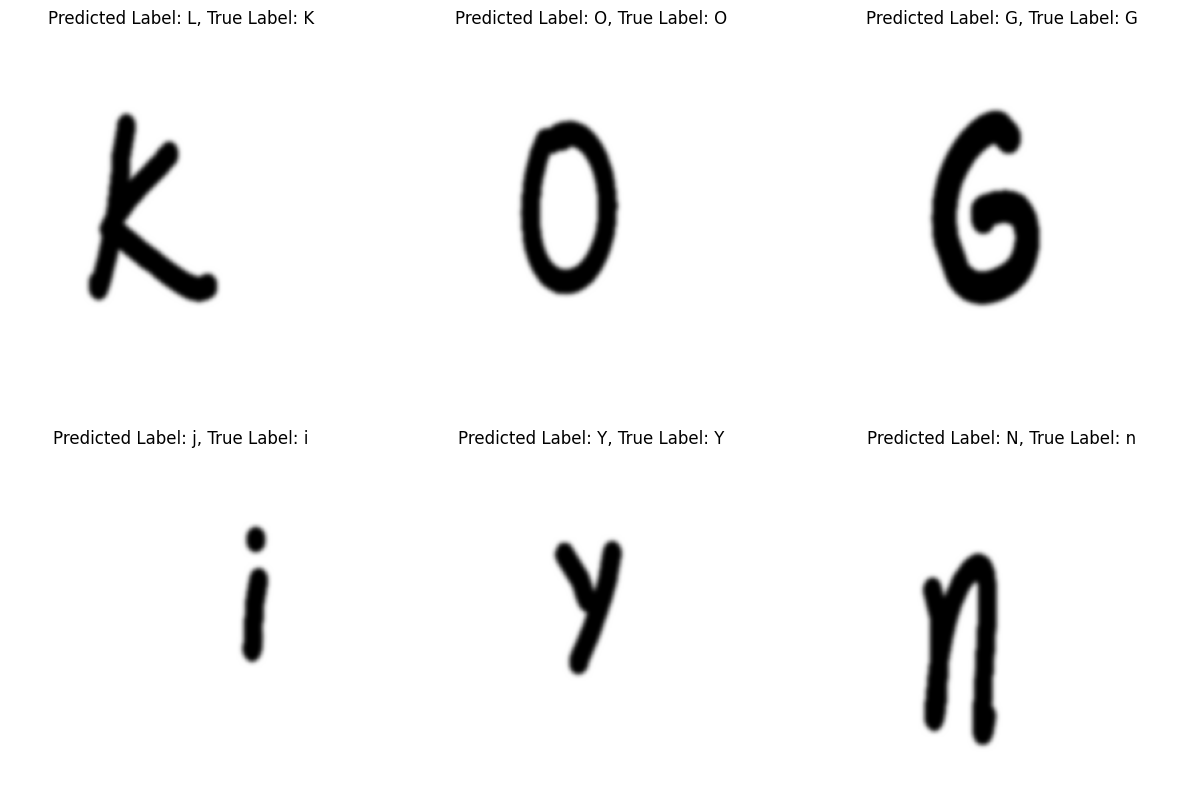

In [12]:
import random

# Randomly select 6 indices from the test set
random_indices = random.sample(range(len(test_images)), 6)

# Predict probabilities for each class for the randomly selected images
y_pred_probs = model.predict(test_images[random_indices])

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Decode the predicted labels
y_pred_labels_decoded = Encoder.inverse_transform(y_pred_labels)

# Decode the true labels
y_true_labels_decoded = Encoder.inverse_transform(test_labels[random_indices])

# Display the randomly selected test images along with their predicted and true labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_images[idx])
    plt.title(f'Predicted Label: {y_pred_labels_decoded[i]}, True Label: {y_true_labels_decoded[i]}')
    plt.axis('off')
plt.show()